In [ ]:
## 기본 라이브러리 호출
import numpy as np
import pandas as pd

## Matplot 호출 및 plotting style 정의 
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['image.cmap'] = 'jet'

# 5. ARIMA Forecasting

## 5.1 Box-Jenkins Approach to non-Seasonal ARIMA Modeling

시계열 데이터 모델링에서는 다음과 같은 반복적인 3가지 스텝으로 가장 fitting이 잘되는 모델과 파라미터를 결정함 (Box-Jenkins)

1. **Model identification** and model selection: 추세, 계절성 등을 파악하고 ACF, PACF 등을 분석하여 AR, MA, 몇차 differncing을 사용해야 하는지 정의.
2. **Parameter** estimation: 위에서 정의한 모델의 파라미터를 데이터를 잘 설명할 수 있도록 구함. Maximum likelihood estimation 등이 사용됨.
3. **Model checking**: 추정한 모델이 stationary process가 맞는지 호가인하는 작업. 특히, fitting된 값의 나머지 부분은 각 부분이 i.i.d 하면서 평균과 분산이 일정해야 함. 추정이 충분치 않다면 1번 스텝으로 돌아가 다시 분석. 


In [ ]:
## 구글 드라이브와 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## load passenger data set and safe to DataFrame
datapath = '/content/drive/MyDrive/Time Series/international-airline-passengers.csv'
df = pd.read_csv(datapath, header=None, index_col=0)
df = df.rename(columns={1: 'passengers'}) # column 명과
df = df.rename_axis('month') # 인덱스 명 바꿈
df.index = pd.to_datetime(df.index, format='%Y-%m') # 인덱스를 datetime format으로
y = df['passengers'] # New pandas Series

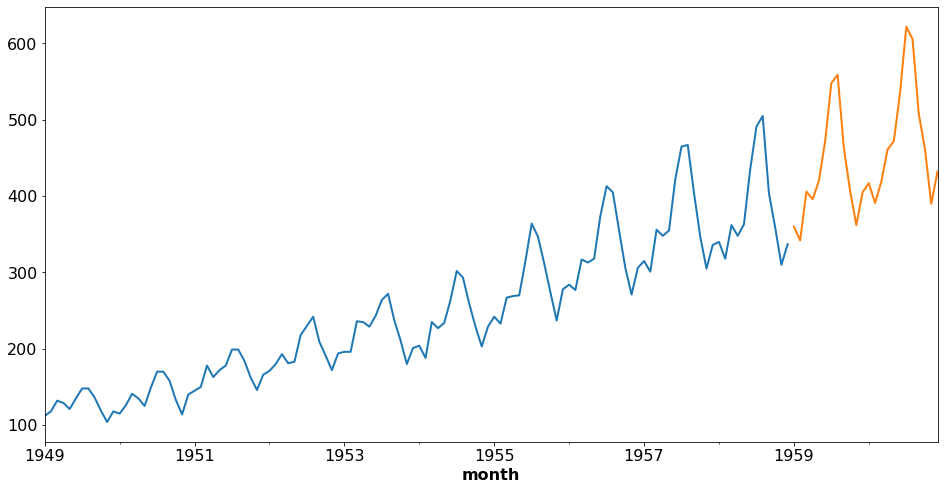

In [ ]:
## Split into training and test sets
y_train = y[:'1958']
y_test = y['1959':]
y_train.plot()
y_test.plot()

## 5.2 Optimal Parameter Selection

Seasonal ARIMA 모델을 fitting 하기 위해서는 $ARIMA(p, d, q)(P, D, Q)s$의 값을 먼저 찾아야함. 이를 위해 grid search를 통해 가능한 모든 파라미터의 조합을 찾아냄. Search space가 크면 탐색에 너무 오랜 시간이 걸리므로 보통 3 미만으로 조절.
$S$ 값을 일반적으로 파악하기 쉬움 (여기서는 12)


In [ ]:
import itertools

In [ ]:
## Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

## Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

파라미터의 가능한 모든 조합들 중에서 가장 작은 AIC를 가진 모델을 최적의 모델로 선택함.


In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
import  statsmodels.api as sm
#from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train, exog=None, order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            
            res = tmp_mdl.fit()        
            print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, res.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1680.2792351899682
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1557.6321470841824
SARIMAX(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1457.624852503332
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1060.4792883429302
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1014.0696747520237
SARIMAX(0, 0, 0)x(0, 1, 2, 12)12 - AIC:979.7489018314452
SARIMAX(0, 0, 0)x(0, 2, 0, 12)12 - AIC:870.3178783692174
SARIMAX(0, 0, 0)x(0, 2, 1, 12)12 - AIC:834.9098987640784
SARIMAX(0, 0, 0)x(0, 2, 2, 12)12 - AIC:836.9046782424216
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1231.9865853935999
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1185.3010979084077
SARIMAX(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1150.7354930056558
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:969.3781382611913
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:951.6330955159025
SARIMAX(0, 0, 0)x(1, 1, 2, 12)12 - AIC:953.6097575901133
SARIMAX(0, 0, 0)x(1, 2, 0, 12)12 - AIC:854.6476586071261
SARIMAX(0, 0, 0)x(1, 2, 1, 12)12 - AIC:836.9044062474019
SARIMAX(0, 0, 0)x(1, 2, 

Grid search로 찾아낸 모델은 ARIMA(1, 1, 0)(1, 2, 1)12. SARIMAX에서 seasonal_order가 주어지지 않으면 ARIMA 모델링 수행함.


In [ ]:
## Define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train, order=(1, 1, 0),
                                seasonal_order=(0, 2, 2, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

# print statistics
print(res.aic)
print(res.summary())

727.3256892864528
                                 Statespace Model Results                                 
Dep. Variable:                         passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 2, 1, 12)   Log Likelihood                -359.663
Date:                            Wed, 17 Mar 2021   AIC                            727.326
Time:                                    10:34:33   BIC                            737.541
Sample:                                01-01-1949   HQIC                           731.454
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.091     -3.909      0.000      -0.536      -0.178
ar.S.L12      -0.

summary 으로 충분한 정보를 얻을 수 있음. coef 부분에서 모델 파라미터의 계수를 알 수 있음. P>|z| 에서 추정한 파라미터의 significance를 알 수 있는는데, p-value가 0.05보다 작으면 reasonable 함.


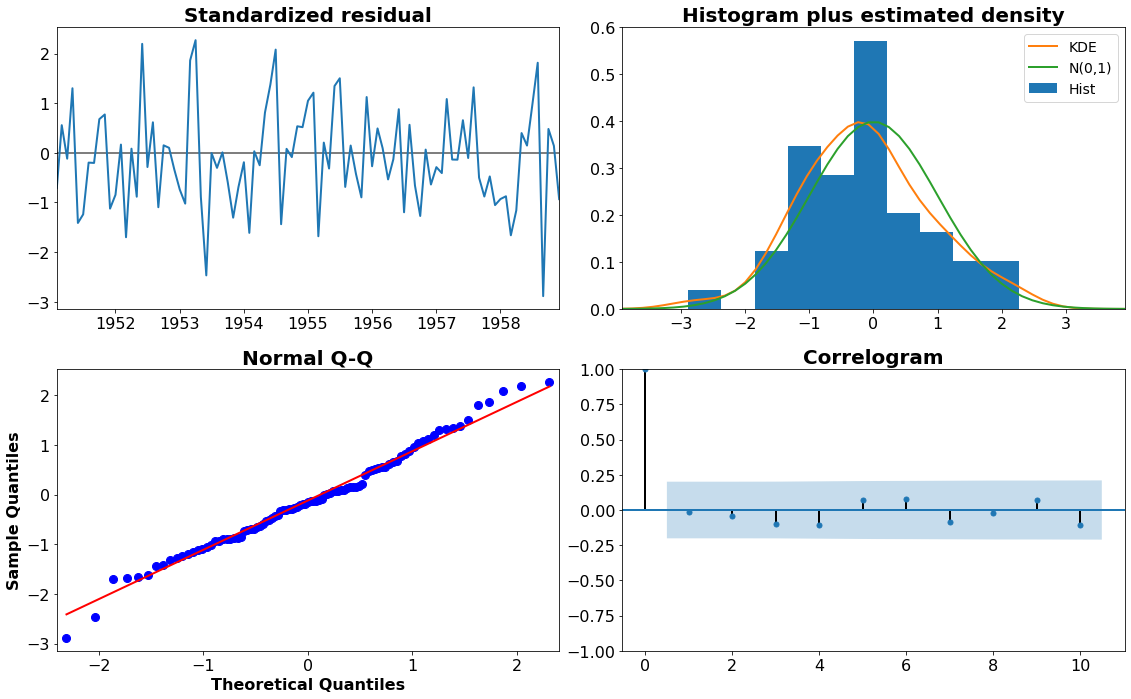

In [ ]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

예측값과 실제값의 차이가 평균이 0이고 uncorrelated 된 것을 확인. 잔차가 white noise와 비슷하지 않다면 더 좋은 모델로 구성해야함.

위의 plot들로 봤을 때, 잔차가 white noise 인 것으로 판단되어 모델이 적합하다고 판단할 수 있음. Grid search space의 탐색 공간을 넓히는 등의 방향으로 더 좋은 모델을 찾아 개선 가능.

## 5.4 One step ahead prediction

get_prediction 과 conf_int로 예측치와 예측 범위를 파악함. 정확한 예측을 위해 예측치를 다음값으로 사용하게끔 dynamic=True 로 설정.


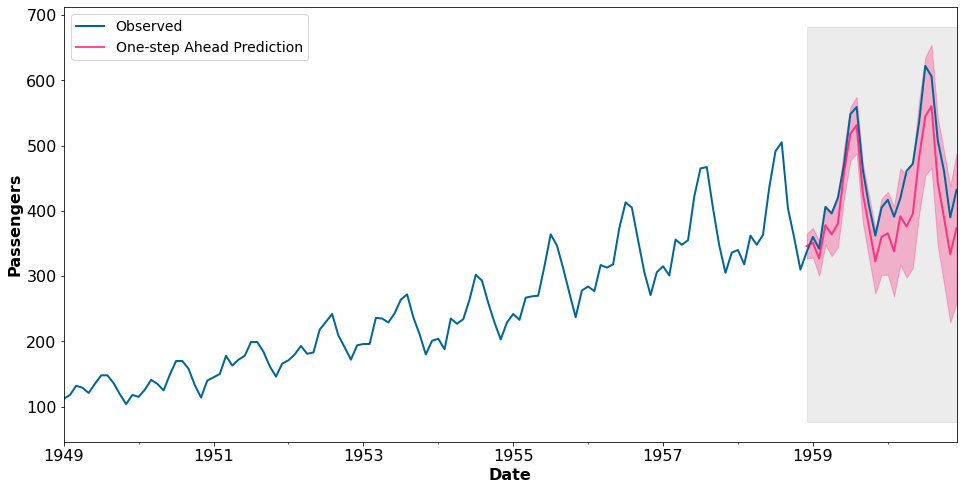

In [ ]:
## Fit model to data
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 0),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

## In-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                          end=pd.to_datetime('1960-12-01'),
                          dynamic=True)
pred_ci = pred.conf_int()

## Plot in-sample-prediction
ax = y['1949':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

## style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend(loc='upper left');
plt.show()

정확도를 측정하기 위해 MSE를 사용.

$$
MSE = \frac{1}{T} \sum_{t=1}^T \left(\hat{y}_t - y_t \right)^2
$$

In [ ]:
import math

In [ ]:
y_hat = pred.predicted_mean
y_true = y['1958-12-01':]

## Compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 2305.03 MSE (48.01 RMSE)


먼 미래로 예측할수록 예측치의 범위가 점점 커짐. 또한, 예측치의 추이가 실제값을 underestimate 하는데 이는 SARIMA 모델로 설명하지 못한 pattern 있는 것으로 판단됨.


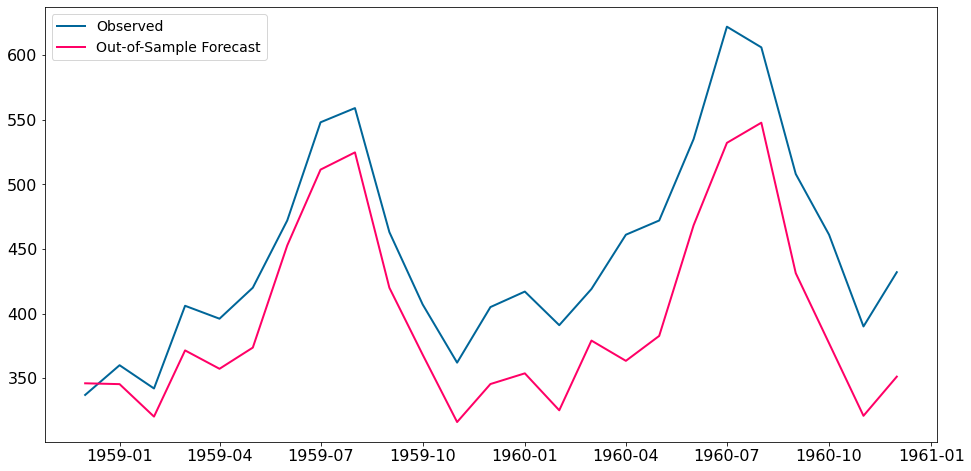

In [ ]:
plt.plot(y_true, label='Observed', color='#006699')
plt.plot(y_hat, label='Out-of-Sample Forecast', color='#ff0066')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left')
plt.show()

## Long term forecasting

10년 후를 예측하기 위해 전체 시계열 y를 사용해 예측.
Grid search로 SARIMAX(2, 1, 3)(1, 2, 1)12 찾음.


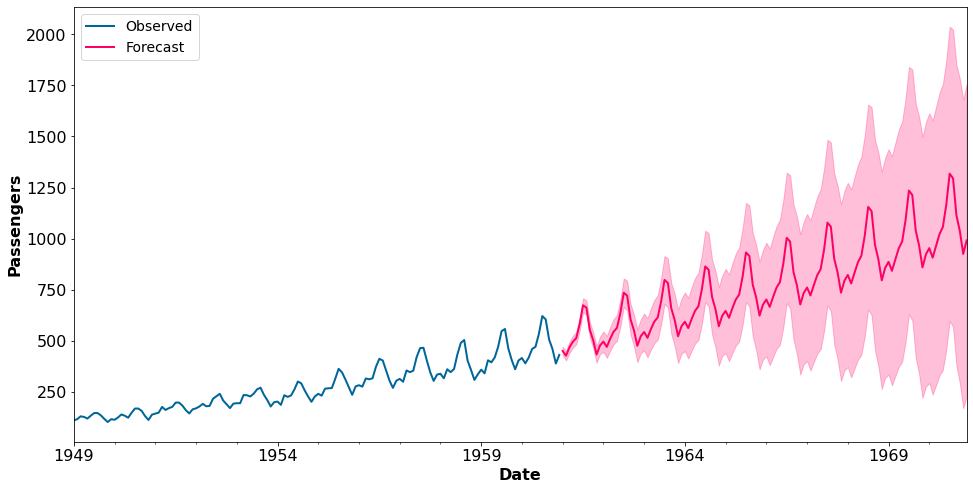

In [ ]:
## Build model and fit
res = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 3),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

## Get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=120)

## Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

## Plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left')
plt.show()

예측 부분을 살펴보면 추세가 점점 증가하면서 분산도 커지는 것을 알 수 있음. 또한, 예측치 분산이 점점 증가하므로 먼 미래의 대한 예측을 신뢰하기가 어려움.
